## BO with Warped Gaussian Processes

In this tutorial, we illustrate how to use learned input warping functions for robust Bayesian Optimization when the outcome may be non-stationary functions. When the lengthscales are non-stationarity in the raw input space, learning a warping function that maps raw inputs to a warped space where the lengthscales are stationary can be useful, because then standard stationary kernels can be used to effectively model the function.

In general, for a relatively simple setup (like this one), we recommend using [Ax](https://ax.dev), since this will simplify your setup (including the amount of code you need to write) considerably. See the [Using BoTorch with Ax](/docs/tutorials/custom_botorch_model_in_ax) tutorial. To use input warping with `MODULAR_BOTORCH`, we can pass the `warp_tf`, constructed as below, by adding `input_transform=warp_tf` argument to the `Surrogate(...)` call. 

We consider use a Kumaraswamy CDF as the class of input warping function and learn the concentration parameters ($a>0$ and $b>0$). Kumaraswamy CDFs are quite flexible and map inputs in [0, 1] to outputs in [0, 1]. This work follows the Beta CDF input warping proposed by Snoek et al., but replaces the Beta distribution Kumaraswamy distribution, which has a *differentiable* and closed-form CDF. 
   
   $$K_\text{cdf}(x) = 1 - (1-x^a)^b$$
   
This enables maximum likelihood (or maximum a posteriori) estimation of the CDF hyperparameters using gradient methods to maximize the likelihood (or posterior probability) jointly with the GP hyperparameters. (Snoek et al. use a fully Bayesian treatment of the CDF parameters). Each input dimension is transformed using a separate warping function.

We use the Log Noisy Expected Improvement (qLogNEI) acquisition function to optimize a synthetic Hartmann6 test function. The standard problem is

$$f(x) = -\sum_{i=1}^4 \alpha_i \exp \left( -\sum_{j=1}^6 A_{ij} (x_j - P_{ij})^2  \right)$$

over $x \in [0,1]^6$ (parameter values can be found in `botorch/test_functions/hartmann6.py`). For this demonstration,
We first warp each input dimension through a different inverse Kumaraswamy CDF.

Since BoTorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_{x} -f(x) = 3.32237$.

[1] [J. Snoek, K. Swersky, R. S. Zemel, R. P. Adams. Input Warping for Bayesian Optimization of Non-Stationary Functions. Proceedings of the 31st International Conference on Machine Learning, PMLR 32(2):1674-1682, 2014.](http://proceedings.mlr.press/v32/snoek14.pdf)

In [ ]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import os
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

### Problem setup

First, we define the sample parameters for the sigmoid functions that transform the respective inputs.

Text(0, 0.5, 'Transformed Value')

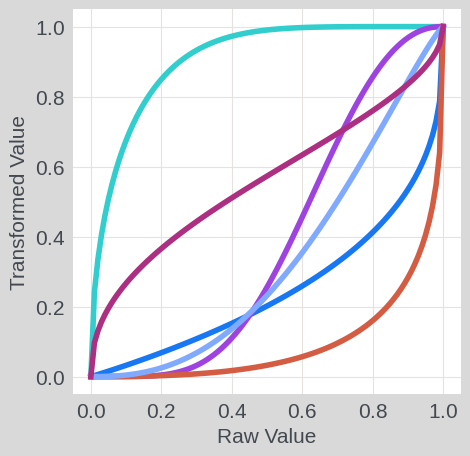

In [3]:
from torch.distributions import Kumaraswamy
import matplotlib.pyplot as plt

%matplotlib inline


fontdict = {"fontsize": 15}
torch.manual_seed(1234567890)
c1 = torch.rand(6, dtype=dtype, device=device) * 3 + 0.1
c0 = torch.rand(6, dtype=dtype, device=device) * 3 + 0.1
x = torch.linspace(0, 1, 101, dtype=dtype, device=device)
k = Kumaraswamy(concentration1=c1, concentration0=c0)
k_icdfs = k.icdf(x.unsqueeze(1).expand(101, 6))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in range(6):
    ax.plot(x.cpu(), k_icdfs[:, i].cpu())
ax.set_xlabel("Raw Value", **fontdict)
ax.set_ylabel("Transformed Value", **fontdict)

In [4]:
from botorch.test_functions import Hartmann

neg_hartmann6 = Hartmann(negate=True)


def obj(X):
    X_warp = k.icdf(X)
    return neg_hartmann6(X_warp)

#### Initial design

The models are initialized with 14 points in $[0,1]^6$ drawn from a scrambled sobol sequence.

We observe the objectives with additive Gaussian noise with a standard deviation of 0.05.

In [5]:
from botorch.models import SingleTaskGP
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.sampling import draw_sobol_samples

NOISE_SE = 0.05
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)

bounds = torch.tensor([[0.0] * 6, [1.0] * 6], device=device, dtype=dtype)


n = 14
# generate initial training data
train_x = draw_sobol_samples(
    bounds=bounds, n=n, q=1, seed=torch.randint(0, 10000, (1,)).item()
).squeeze(1)
exact_obj = obj(train_x).unsqueeze(-1)  # add output dimension

best_observed_value = exact_obj.max().item()
train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)

#### Input warping and model initialization
We initialize the `Warp` input transformation and pass it a `SingleTaskGP` to model the noiseless objective. The `Warp` object is a `torch.nn.Module` that contains the concentration parameters and applies the warping function in the `Model`'s `forward` pass.

In [6]:
from botorch.models.transforms.input import Warp
from gpytorch.priors.torch_priors import LogNormalPrior


def initialize_model(train_x, train_obj, bounds):
    # initialize input_warping transformation
    warp_tf = Warp(
        d=train_x.shape[-1],
        indices=list(range(train_x.shape[-1])),
        # use a prior with median at 1.
        # when a=1 and b=1, the Kumaraswamy CDF is the identity function
        concentration1_prior=LogNormalPrior(0.0, 0.75**0.5),
        concentration0_prior=LogNormalPrior(0.0, 0.75**0.5),
        bounds=bounds,
    )
    # define the model for objective
    model = SingleTaskGP(
        train_X=train_x,
        train_Y=train_obj,
        train_Yvar=train_yvar.expand_as(train_obj),
        input_transform=warp_tf,
    ).to(train_x)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper function that performs the essential BO step
The helper function below takes an acquisition function as an argument, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. For this example, we'll use sequential $q=1$ optimization. A simple initialization heuristic is used to select the 20 restart initial locations from a set of 512 random points. 

In [7]:
from botorch.optim import optimize_acqf


num_restarts = 20 if not SMOKE_TEST else 2
raw_samples = 512 if not SMOKE_TEST else 32


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=num_restarts,
        raw_samples=raw_samples,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    exact_obj = obj(new_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    return new_x, train_obj


### Perform Bayesian Optimization
The Bayesian optimization loop iterates the following steps:
1. given a surrogate model, choose a candidate point $x$
2. observe $f(x)$
3. update the surrogate model. 

We do `N_BATCH=50` rounds of optimization.

In [8]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

N_BATCH = 50 if not SMOKE_TEST else 5

torch.manual_seed(0)

best_observed = [best_observed_value]
mll, model = initialize_model(train_x, train_obj, bounds)

# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(1, N_BATCH + 1):

    # fit the models
    fit_gpytorch_mll(mll)
    ei = qLogNoisyExpectedImprovement(model=model, X_baseline=train_x)

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(ei)

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # update progress
    best_value = obj(train_x).max().item()
    best_observed.append(best_value)

    mll, model = initialize_model(train_x, train_obj, bounds)

    print(".", end="")

..................................................

#### Plot the results
The plot below shows the log regret at each step of the optimization for each of the algorithms.

Text(0, 0.5, 'Log10 Regret')

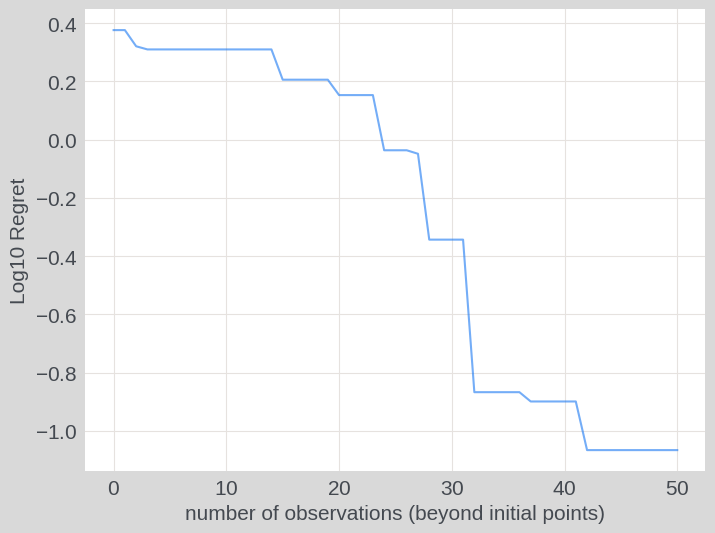

In [9]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


GLOBAL_MAXIMUM = neg_hartmann6.optimal_value

iters = np.arange(N_BATCH + 1)
y_ei = np.log10(GLOBAL_MAXIMUM - np.asarray(best_observed))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(
    iters,
    y_ei,
    linewidth=1.5,
    alpha=0.6,
)

ax.set_xlabel("number of observations (beyond initial points)")
ax.set_ylabel("Log10 Regret")